### Twitter Hate Speech Analysis
When working on a supervised machine learning problem with a given data set, we try different algorithms and techniques to search for models to produce general hypotheses, which then make the most accurate predictions possible about future instances. The same principles apply to text (or document) classification where there are many models can be used to train a text classifier. 

We are going tp train multiple models to compare and decide which one is the best model.

### The Data
The data we are using from twitter.The data file contains 5 columns:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [1]:
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit
import gensim
import re
import logging
from numpy import random
from bs4 import BeautifulSoup

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from gensim.models import Word2Vec  

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline



#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
#warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('labeled_data.csv')
#df = df[pd.notnull(df['class'])]
#df = df.head(5000)
print(df.head(10))
print(df['tweet'].apply(lambda x: len(x.split(' '))).sum())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   
5           5      3            1                   2        0      1   
6           6      3            0                   3        0      1   
7           7      3            0                   3        0      1   
8           8      3            0                   3        0      1   
9           9      3            1                   2        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Da

We have over 3 million words in. tweets

In [3]:
#0 - hate speech 1 - offensive language 2 - neither
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [4]:
df['class']=[1 if b == 2 else 0 for b in df['class']] # merged the 0-hate speech 1-offensive language into 1 and neither into 0
# Transform into binary classification
#df['class'] = [1 if b == 2 else 0 for b in df['class']]
df['class'].value_counts()

0    20620
1     4163
Name: class, dtype: int64

Text(0,0.5,'count')

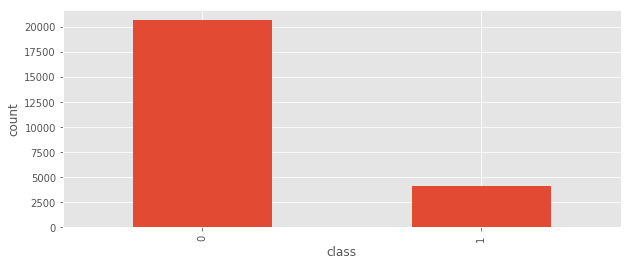

In [5]:
# Shape of our data
df.columns
df.head(10)
plt.figure(figsize=(10,4))
ax=df['class'].value_counts().plot(kind='bar');
ax.set_xlabel("class")
ax.set_ylabel("count")

### Text Pre-processing
The text cleaning techniques we have seen so far work very well in practice. Depending on the kind of texts you may encounter, it may be relevant to include more complex text cleaning steps. But keep in mind that the more steps we add, the longer the text cleaning will take.
For this particular data set, our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['tweet'] = df['tweet'].apply(clean_text)
df.head(10)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,rt mayasolovely woman shouldnt complain cleani...
1,1,3,0,3,0,0,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,2,3,0,3,0,0,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,3,0,2,1,0,rt c_g_anderson viva_based look like tranny
4,4,6,0,6,0,0,rt shenikaroberts shit hear might true might f...
5,5,3,1,2,0,0,t_madison_x shit blows meclaim faithful somebo...
6,6,3,0,3,0,0,__brighterdays sit hate another bitch got much...
7,7,3,0,3,0,0,selfiequeenbri cause im tired big bitches comi...
8,8,3,0,3,0,0,might get ya bitch back thats
9,9,3,1,2,0,0,rhythmixx_ hobbies include fighting mariambitch


In [7]:
df['tweet'].apply(lambda x: len(x.split(' '))).sum()

227320

After text cleaning and removing stop words, we have only over 2 million words to work with!
After splitting the data set, the next steps includes feature engineering. 
We will convert our text documents to a matrix of token counts (CountVectorizer).

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

#vect is set up with default params to tokenize and lowercase words. On top of that, we have set binary=True so we get an output of 0 (word doesn't exist in that sentence) or 1 (word exists in that sentence).

#vect builds a vocabulary from all the words it sees in all the text you give it, then assigns a 0 or 1 if that word exists in the current sentence. 

vect = CountVectorizer(max_features=24783,binary=True)
X = vect.fit_transform(df['tweet'])

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Preparing for Training
Before training, and even vectorizing, let's split our data into training and testing sets. It's important to do this before doing anything with the data so we have a fresh test set.

In [9]:
from sklearn.model_selection import train_test_split

X = df.tweet    # predictor
y = df['class'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Our test size is 0.2, or 20%. This means that X_test and y_test contains 20% of our data which we reserve for testing.

Let's now fit the vectorizer on the training set only and perform the vectorization.

Just to reiterate, it's important to not fit the vectorizer on all of the data since we want a clean test set for evaluating performance. Fitting the vectorizer on everything would result in data leakage, causing unreliable results since the vectorizer shouldn't know about future data.

In [10]:
#To see this more clearly, let's check out the feature names mapped to the first sentence:
#list(zip(X.toarray()[0], vect.get_feature_names()))

In [11]:
#We can fit the vectorizer and transform X_train in one step:

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=24783, binary=True)

X_train_vect = vect.fit_transform(X_train)

X_train_vect is now transformed into the right format to give to the Naive Bayes model, but let's first look into balancing the data.



### Balancing the Data
It seems that there may be a lot more negative tweets than positive tweets, and so we have a lot more negative labels than positive labels.



In [12]:
counts = df['class'].value_counts()
print(counts)

print("\nPredicting only 0 = {:.2f}% accuracy".format(counts[0] / sum(counts) * 100))

0    20620
1     4163
Name: class, dtype: int64

Predicting only 0 = 83.20% accuracy


We can see from above, we have  more negatives than positives, making our dataset clearly imbalanced.

By calculating if our model only chose to predict 0(hate and offensive language), the larger class, we would get a ~60% accuracy. This means that in our binary classification model, where random chance is 50%, a 60% accuracy wouldn't tell us much. We would definitely want to look at precision and recall more than accuracy.

We can balance our data by using a form of oversampling called SMOTE. SMOTE looks at the minor class, neutrals in our case, and creates new, synthetic training examples. 

Let's perform SMOTE with the imblearn library:

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

# X_train_res, y_train_res are balanced datasets
X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [14]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(0, 16456), (1, 16456)]


The classes are now balanced for the train set. We can move onto training a Naive Bayes model.

## Naive Bayes
For our first algorithm, we're going to use the extremely fast and versatile Naive Bayes model.

Let's instantiate one from sklearn and fit it to our training data:

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
  

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)# 

nb.score(X_train_res, y_train_res)


0.8125

Naive Bayes has successfully fit all of our training data and is ready to make predictions. You'll notice that we have a score of ~82%. This is the fit score, and not the actual accuracy score. You'll see next that we need to use our test set in order to get a good estimate of accuracy.

Let's vectorize the test set, then use that test set to predict if each test tweet is either positive or negative. Since we're avoiding any data leakage, we are only transforming, not refitting. And we won't be using SMOTE to oversample either.

In [18]:
X_test_vect = vect.transform(X_test)

predictions = nb.predict(X_test_vect)


print(confusion_matrix(y_test, predictions))  
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))





[[3982  123]
 [ 225  627]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4105
           1       0.84      0.74      0.78       852

   micro avg       0.93      0.93      0.93      4957
   macro avg       0.89      0.85      0.87      4957
weighted avg       0.93      0.93      0.93      4957

0.9297962477304822


y_pred now contains a prediction for every row of the test set. With this prediction result, we can pass it into an sklearn metric with the true labels to get an accuracy score, F1 score, and generate a confusion matrix:

In [66]:
from sklearn.model_selection import ShuffleSplit

X = df['tweet']
y = df['class']

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

In [67]:
for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 93.12%

Average F1 score across folds: 78.15%

Average Confusion Matrix across folds: 
 [[4005.3  116. ]
 [ 225.1  610.6]]


Looks like the average accuracy and F1 score are both similar to what we saw on a single fold above.



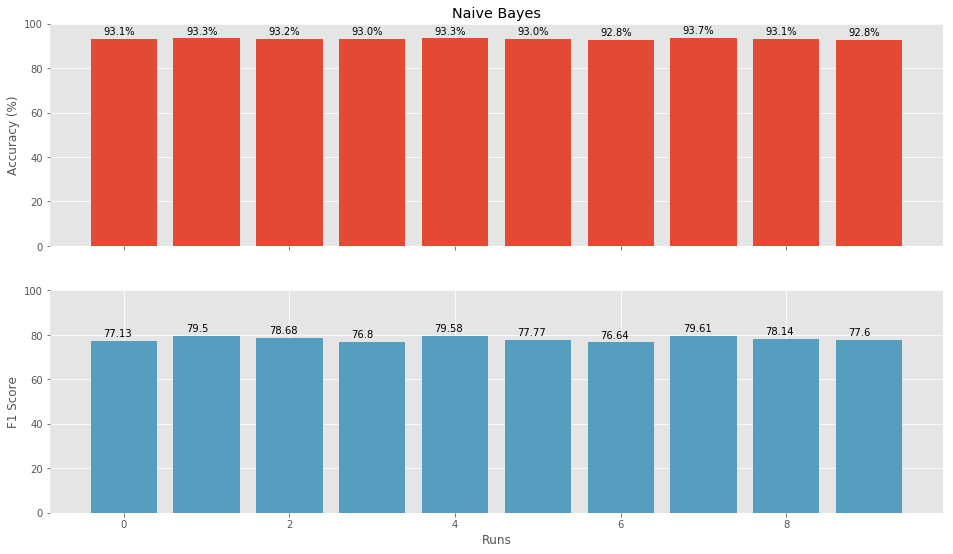

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

### KNN (K-Nearest Neighbors)

In [20]:
from sklearn.neighbors import KNeighborsClassifier  
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train_res, y_train_res) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [21]:
X_test_vect = vect.transform(X_test)

predictions = knn.predict(X_test_vect)


print(confusion_matrix(y_test, predictions))  
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))



[[2261 1844]
 [   3  849]]
              precision    recall  f1-score   support

           0       1.00      0.55      0.71      4105
           1       0.32      1.00      0.48       852

   micro avg       0.63      0.63      0.63      4957
   macro avg       0.66      0.77      0.59      4957
weighted avg       0.88      0.63      0.67      4957

0.6273956021787371


Other Classification Algorithms in scikit-learn
As you can see Naive Bayes performed pretty well, so let’s experiment with other classifiers.

We'll use the same shuffle splitting as before, but now we'll run several types of models in each loop:

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


X = df['tweet']
y = df['class']

cv = ShuffleSplit(n_splits=20, test_size=0.2)

models = [
    MultinomialNB(),
    LogisticRegression(),
    LinearSVC(),
    RandomForestClassifier()
   
]

sm = SMOTE()

# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)

/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

We now have a bunch of accuracy scores, f1 scores, and confusion matrices stored for each model. Let's average these together to get average scores across models and folds:

In [70]:
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

MultinomialNB
------------------------------
        Avg. Accuracy: 93.17%
        Avg. F1 Score: 78.44
        Avg. Confusion Matrix: 
        
[[4002.25  120.3 ]
 [ 218.15  616.3 ]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 94.36%
        Avg. F1 Score: 84.38
        Avg. Confusion Matrix: 
        
[[3922.2   200.35]
 [  79.15  755.3 ]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 94.44%
        Avg. F1 Score: 84.15
        Avg. Confusion Matrix: 
        
[[3949.4   173.15]
 [ 102.5   731.95]]
        
RandomForestClassifier
------------------------------
        Avg. Accuracy: 91.22%
        Avg. F1 Score: 72.58
        Avg. Confusion Matrix: 
        
[[3945.    177.55]
 [ 257.7   576.75]]
        


### Esembling Classifiers
After we evaluated each classifier individually, let's see if ensembling helps improve our metrics.

We're going to use sklearn's VotingClassifier which defaults to a majority rule voting.

In [71]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

X = df['tweet']
y = df['class']

cv = ShuffleSplit(n_splits=10, test_size=0.2)

models = [
    MultinomialNB(),
    
    LogisticRegression(),
    
    LinearSVC(),
    RandomForestClassifier(),
    
]




m_names = [m.__class__.__name__ for m in models]

models = list(zip(m_names, models))
vc = VotingClassifier(estimators=models)
#bc = BaggingClassifier(estimators=models)

sm = SMOTE()

# No need for dictionary now
accs = []
f1s = []
cms = []

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    vc.fit(X_train_res, y_train_res)
    
    y_pred = vc.predict(X_test_vect)
    
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
print("Voting Classifier")
print("-" * 30)
print("Avg. Accuracy: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("Avg. F1 Score: {:.2f}".format(sum(f1s) / len(f1s) * 100))
print("Confusion Matrix:\n", sum(cms) / len(cms))


/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sumairaafzal/anaconda3/lib/python3.6/site-packages/sklearn/

Voting Classifier
------------------------------
Avg. Accuracy: 94.05%
Avg. F1 Score: 81.45
Confusion Matrix:
 [[4013.8  124.7]
 [ 170.4  648.1]]


### Conclusion and further precursor
So far we've

- Mined data from twitter
- Obtained  scores for tweets
- cleaned the data
- Vectorized the data
- Run the data through several types of models
- Ensembled models together
Unfortunately, there isn't an obvious winning model. There's a couple we've seen that definitely perform poorly, but there's a few that hover around the same accuracy. 

We have seen  how this pipeline works, there's a lot of room for improvement on the architecture of the code and modeling. 